# CE 5362 Lesson 6 Computational Workshop

This computational workshop is to examine computation related to:

1. Uniform flow; algebraic equation.
$$ S_f = S_0 $$

2. Gradually varied; ordinary differential equation.
$$ S_f = S_0 - \frac{\partial z}{\partial x} - \frac{V}{g}\frac{\partial V}{\partial x} $$

3. Dynamic flow (shallow wave) conditions; partial differential equation.

$$ S_f = S_0 - \frac{1}{g} \frac{\partial V}{\partial t} - \frac{\partial z}{\partial x} - \frac{V}{g}\frac{\partial V}{\partial x} $$

The objectives are to explore the JupyterLab environment to make relevant computations, then compare results to the professional tools (SWMM)




## Gradually Varied Steady Flow

### Fixed Depth Change, Variable Spatial Step
The fixed-step refers to specified changes in depth for which we solve to find the variable spatial steps. The method is a very simple method for computing water surface profiles in prismatic channels. A prismatic channel is a channel of uniform cross sectional geometry with constant bed (topographic) slope.

In such channels with smooth (non-jump) steady flow the continunity and momentum equations are: 

$$Q = AV $$

where where $Q$ is volumetric discharge, $A$ is cross sectional flow area, and $V$ is the mean section velocity; and: 

$$\frac{V}{g} \frac{dV}{dx}+\frac{dh}{dx} = S_o - S_f$$ 

where $h$ is the flow depth (above the bottom), and $x$ is horizontal the distance along the channel.

For the variable step method, the momentum equation is rewritten as a difference equation (after application of calculus to gather terms) then rearranged to solve for the spatial step dimension .

$$ \frac{\frac{V^2_{i+1}}{2g}-\frac{V^2_{i}}{2g}}{\Delta x} + \frac{h_{i+1}-h_{i}}{\Delta x} = S_o - \bar{S_f} $$

where $S_f$ is the average slope of the energy grade line between two sections (along a
reach of length $\Delta x$, the unknown value). Rearrangement to isolate $\Delta x$ produces an explicit update equation that can be evaluated to find the different values of $\Delta x$ associated with different flow depths. The
plot of the accumulated spatial changes versus the sum of the flow depth and bottom elevation is the water surface profile.

$$\frac{(h_{i+1} + \frac{V^2_{i+1}}{2g})  -  (h_{i} +\frac{V^2_{i}}{2g}) }{S_o - \bar{S_f} } = \Delta x $$

The distance between two sections with known discharges is computed using the
equation, all the terms on the left hand side are known values. The mean energy
gradient ($\bar{S_f}$ ) is computed from the mean of the velocity, depth, area, and hydraulic
radius for the two sections.

The friction slope can be computed using Manning's, Chezy, or the Darcy-Weisbach friction equations adapted for non-circular, free-surface conduits.

The equation here is written moving upstream, direction matters for indexing. Thus position $i+1$
is assumed upstream of position $i$ in this notebook. Such directional convention is unusual in
numerical methods and analysts need to use care when developing their own tools or using other
tools. A clever analyst need not rewrite code, but simple interchange of upstream and downstream
depths can handle both backwater and front-water curves.

## Scripting an Algorithm

Here the method is illustrated in  to illustrate the tool as a programming environment.
First we build a set of utility functions, these will be used later in the `backwater`
function

The listings below are utility functions for rectangular channels for flow area given channel
depth and width and wetted perimeter given depth and width. Different geometries will need different functions (probably by numerical methods rather than actual functional relationships).


The first listing is a depth-area function for rectangular geometry.

In [1]:
# Depth-Area function for rectangular channel
def area(depth,width):
    area=depth*width;
    return(area)

The next listing is a depth wetted-perimeter function for a rectangular geometry.

In [2]:
# Depth-Wetted perimeter function for rectangular channel
def perimeter(depth,width):
    perimeter=2*depth+width;
    return(perimeter)

Listing below is a listing of the code for the hydraulic radius (ratio of the above results),
this is a generic function, it does not need to know the flow geometry

In [3]:
# Hydraulic radius function
def radius(area,perimeter):
    radius=area/perimeter;
    return(radius)

The next section is a listing of code for the friction slope given Manning's n, discharge,
hydraulic radius, and flow area. This function implicitly assumes SI units
(the 1.49 constant in U.S. Customary units is not present). For U.S. Customary units
either add the constant or convert the US units into equivalent SI units.

In [4]:
# Friction slope function
def slope_f(discharge,mannings_n,area,radius):
    slope_f=(discharge**2)*(mannings_n**2)/( (radius**(4./3))*(area**2) ); #compute friction slope
    return(slope_f)

In [5]:
# 2-point average
def avg2point(x1,x2):
    avg2point=0.5*(x1+x2);
    return(avg2point)

The semi-colons in the functions are probably unnecessary, but have value because it
forces the expression to its left to be evaluated and helps prevent ambiguous code.
Also notice the use of indention as a scope delimiter, the delimiter is required. 

## Describe the actual BW computes

At this point, we have 5 useful, testable functions (and we should test before
the next step.

The next listing is the step-backwater method implemented as a function. This function
computes the space steps, changes in depth, etc. as per the algorithm. The function is a **FORTRAN** port, so it is not a terribly efficient use of **JupyterLab/iPython**, but it illustrates count controlled repetition (for loops), array indexing, and use of the utility functions to make the code readable as well as ensure that the parts work before the whole program is assembled. This concept is really crucial, if you can build a tool of parts that are known to work, it helps keep logic errors contained to known locations.

In [6]:
# Backwater curve function
def backwater(begin_depth,end_depth,how_many,discharge,width,mannings_n,slope):
#
## Example function call
##  zz = backwater(begin_depth=8,end_depth=5,how_many=30,discharge=55.4,width=5,mannings_n=0.02,slope=0.001)
## Numerical values are values used in essay, they correspond to a particuar example from Koutitas 1983
#
# Other functions must exist otherwise will spawn errors
#
# Prepare space for vectors
    twog=2.0*9.8
    depth=[]  # numeric vector for depths
    velocity=[]  # numeric vector for velocities
    deltax=[] # numeric vector for spatial steps
    distance=[] # space for computing cumulative distances
    bse=[] # numeric vector for bottom elevations
    wse=[] # numeric vector for water surface elevations
    delta_depth=(begin_depth-end_depth)/(how_many)  # change in depth for finding spatial steps
    #print(delta_depth)
    depth.append(begin_depth) # assign downstream value
    for i in range(1,how_many):
        depth.append(depth[0] - (i+1)*delta_depth) # uniform depths
    for i in range(0,how_many):
        velocity.append(discharge/area(depth[i],width))
    for i in range(0,how_many-1):
        depth_bar=avg2point(depth[i+1],depth[i]); #compute average depth in reach
        area_bar=area(depth_bar,width); #compute average area in reach
        perimeter_bar=perimeter(depth_bar,width); #compute average wetted perimeter
        radius_bar=radius(area_bar,perimeter_bar); #compute average hydraulic radius
        friction=slope_f(discharge,mannings_n,area_bar,radius_bar) #compute friction slope
        snrgup =(depth[i+1]+((velocity[i+1]**2)/twog))
        snrgdn =(depth[i] + ((velocity[i]**2)/twog))
        step =(snrgup - snrgdn)/(slope-friction) # compute change in distance for each change in depth
        deltax.append(step)
    distance.append(0.0)
    bse.append(0.0)
    for i in range(1,how_many):
        distance.append(distance[i-1]+deltax[i-1]); # spatial distances
        bse.append(bse[i-1]-deltax[i-1]*slope); # bottom elevations
    for i in range(0,how_many):
        wse.append(bse[i]+depth[i]) # water surface elevations
    return(distance,wse,bse,depth,deltax,velocity)

### Example Backwater curve
Figure 1 is a backwater curve for a rectangular channelwith discharge over a weir (on
the right hand side — not depicted). The channel width is 5 meters, bottom slope
0.001, Manning’s n = 0.02 and discharge $Q = 55.4m^3/sec$
Using the backwater function and some plot calls in **JupyterLab/iPython** we can duplicate the figure (assuming the figure is essentially correct).

![](bw_curve1.jpg)

|Figure XX. Prismatic Rectangular Channel|
|---|

    This example is adapted from: Page 85. Koutitas, C.G. (1983). Elements of Computational Hydraulics. Pentech Press, London 138p. ISBN 0-7273-0503-4

### Function call with plotting

In [7]:
# call the function - output is a tuple, use this fact in the plotting build
output = backwater(begin_depth=8.0,end_depth=5.0,how_many=31,discharge=55.4,width=5.0,mannings_n=0.02,slope=0.001)
# Now plot the water surface profile

In [8]:
output

([0.0,
  -283.35036151530664,
  -428.01121940864573,
  -574.8515686316364,
  -724.0432559775297,
  -875.7784626846135,
  -1030.2730147587363,
  -1187.770394158555,
  -1348.5466367108593,
  -1512.9163627853982,
  -1681.2402702549975,
  -1853.9345367975611,
  -2031.4827466068946,
  -2214.451200843967,
  -2403.508832956717,
  -2599.4534970171985,
  -2803.247243443978,
  -3016.0645395117012,
  -3239.3595860271253,
  -3474.962585192671,
  -3725.221306601451,
  -3993.2161853820994,
  -4283.100097607726,
  -4600.660902930245,
  -4954.3084661830835,
  -5356.938830438938,
  -5829.813146361424,
  -6411.7849250248955,
  -7186.094269450929,
  -8389.539642756294,
  -11393.20102883886],
 [8.0,
  8.089801974418533,
  8.137688638763485,
  8.187754794438089,
  8.240172288235593,
  8.29513330139429,
  8.352853659920026,
  8.413576845771459,
  8.477578894775375,
  8.545174427301527,
  8.61672414122274,
  8.692644214216916,
  8.773418230477862,
  8.859612491166548,
  8.95189592973091,
  9.051066400243004,

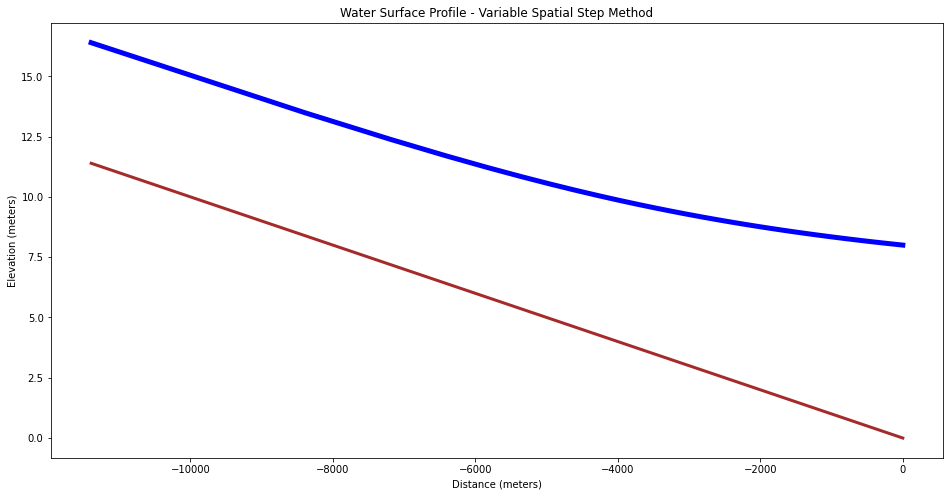

In [9]:
import matplotlib.pyplot
myfigure = matplotlib.pyplot.figure(figsize = (16,8)) # generate a object from the figure class, set aspect ratio
# Built the plot
matplotlib.pyplot.plot(output[0], output[2],  color ='brown', linewidth=3)
matplotlib.pyplot.plot(output[0], output[1],  color ='blue', linewidth=5)
matplotlib.pyplot.ylabel("Elevation (meters)")
matplotlib.pyplot.xlabel("Distance (meters)")
mytitle = "Water Surface Profile - Variable Spatial Step Method"
matplotlib.pyplot.title(mytitle)
matplotlib.pyplot.show()

---

### Fixed Spatial Step, Variable Depth

The fixed-depth change, variable-space result is a useful tool, but not terribly practical because we mostly perform engineering hydraulics calculations to estimate values (depth, pressure, force) at prescribed locations in space, so we need another approach to the problem where we can prescribe the spatial locations, and solve for the depths.

First the gradually varied flow equation is rearranged for relating the change in specific energy between two section to the spatial difference and the slope differences as

\begin{equation}
\Delta h_s = \Delta (h + \frac{V^2}{2g}) = \Delta x (S_o - S_f)
\label{eqn:gvf-energy-bal}
\end{equation}

The computation of $h_{i+1},V_{i+1}$ from $h_i,V_i$ is performed by iteration.
An initial value for $h_{i+1}$ that is known to be too large is used in the above Equation  along with the known value of $h_i$ to compute a trial value $h_{s(i+1)}$.

Then the trial value is used in the right hand side of the Equation 

\begin{equation}
h_s = (h + \frac{V^2}{2g})
\label{eqn:gvf-energy-newl}
\end{equation}

The two trial values are compared and the next value of $h_{i+1}$ is computed by sucessively decreasing until the two values computed by the difference equation and the definition of specific energy coincide.  The example below uses a method from Hamming to make the comparisons and adjust the guesses until they are sufficiently close enough.

### Example (Non-Prismatic Channel), Fixed Spatial Steps)
A plan view of a rectangular channel of variable width as shown in Figure XX

![](NonPrismaticExample.jpg)

|Figure XX. Non-Prismatic Rectangular Channel|
|---|

The channel conveys $Q=100~m^3/sec$, with a bottom slope of $0.001$ and average Manning's $n$ value of $0.033$.  
A backwater curve is caused by a weir at the downstream end (to the right in the figure) by a 7 meter tall weir.
Flow depth over the weir is at critical depth $h_c = 2.17$ meters.  Normal flow in the upstream portion for 10-meter channel width is $h_n = 5.6$ meters.  Using the fixed space step method determine and plot a profile view of the water surface and channel bottom.

The method employed is attributed to Hamming (cite and link to readings) that implements a Newton's-like method to match the left and right side of the difference equation.  

Here is our algorithm, first we set up some problem constants:

In [10]:
# Hamming's Method for Backwater Curve
imax = 30             #number of computational stations
dx = -1000.0            #spacing between stations
manningsN = 0.033     #mannings n value
slopeChan = 0.001     #channel slope
normalD  = 5.6        #upstream station normal depth
controlD = 9.17       #downstream station control depth
discharge = 100.0       #steady discharge

Next we define the plan view geometry, in this example we explicitly enter the values, but we could just as well read the geometry from a file to generalize the script.

In [11]:
topwidth = [10,10,10,11,12,13,14,13,12,11,10,9,8,7,8,9,10,10,10,10,10,10,10,10,10,10,10,10,10,10]
topwidth = [float(i) for i in topwidth] # use of range() to set indices

With topwidth defined, we can compute values of velocity at the control section (downstream pool in the example). The conrtol section has position 0 in the various lists within our script. Observe the two ways we can populate the vectors with constants, use whichever you fancy!

In [13]:
velo = [0] * imax # allocate a velocity vector, put zeroes everywhere
velo[0] = discharge/topwidth[0]/controlD #set velocity at control section
depth = [0 for i in range(0,imax)] # allocate a depth vector, put zeroes everywhere
spDepth = [0 for i in range(0,imax)] # allocate a sp. depth vector, put zeroes everywhere
spDepthT = [0 for i in range(0,imax)] # allocate a sp. depth vector, put zeroes everywhere

Now set control section depth, and specific energy

In [18]:
depth[0] = controlD # set control section depth
spDepth[0] = ((velo[0]**2)/(2.0*9.81)) + depth[0]

Now we implement the algorithm, starting from section 1 (just upstream of the control section) we use the difference equation and Hamming's method to find a value of depth that satisfies the difference equation.  Here are three loops, an outer one that processes each section and two inner loops that perform the balancing act - notice how the script breaks from a loop, when the conditions are satisfied.

In [24]:
## begin for loop
for i in range(1,imax):
    depth[i] = 10
    difn = 1.0
    dh = 1.0
### begin do while loop 1
    while (dh > 0.0001):
        dif = difn
        ntest = 0
        depth[i] = depth[i]-dh
#### begin do while loop 2
        while (dh > 0):
            velo[i] =discharge/topwidth[i]/depth[i]
            avgDepth = 0.5*(depth[i-1]+depth[i])
            avgTopW = 0.5*(topwidth[i-1]+topwidth[i])
            avgV = discharge/avgTopW/avgDepth
            hydR = avgDepth*avgTopW/(avgTopW+2.0*avgDepth)
            sFric = (avgV**2)*(manningsN**2)/(hydR**(1.33))
            spDepth[i] = spDepth[i-1]+(slopeChan-sFric)*dx
            spDepthT[i] = depth[i]+(velo[i]**2/(2.0*9.81))
            difn = spDepthT[i]-spDepth[i]
 #     print(difn)
#      print(cbind(i,depth[i],spDepth[i],spDepthT[i],dh))
            if(ntest > 0):
                dh = dh/10.0
                break #break from do while loop 2
            if(dif*difn > 0):
                break #break from do while loop 2
            depth[i] = depth[i] + dh
            ntest = 1
#### end do while loop 2
### end do while loop 1
## end for loop

Now we prepare the output for plotting

In [36]:
distance = [0]*imax
bottom = [0]*imax
watersurface = [0]*imax
for i in range(1,imax):
    distance[i] = distance[i-1]+dx 
    bottom[i] = -distance[i]*slopeChan
    watersurface[i] = depth[i]+bottom[i]
watersurface[0] = depth[0]+bottom[0] # don't forget the control section!

Here we just reuse the plotting methods from prior lessons, but substitute in the correct vector names

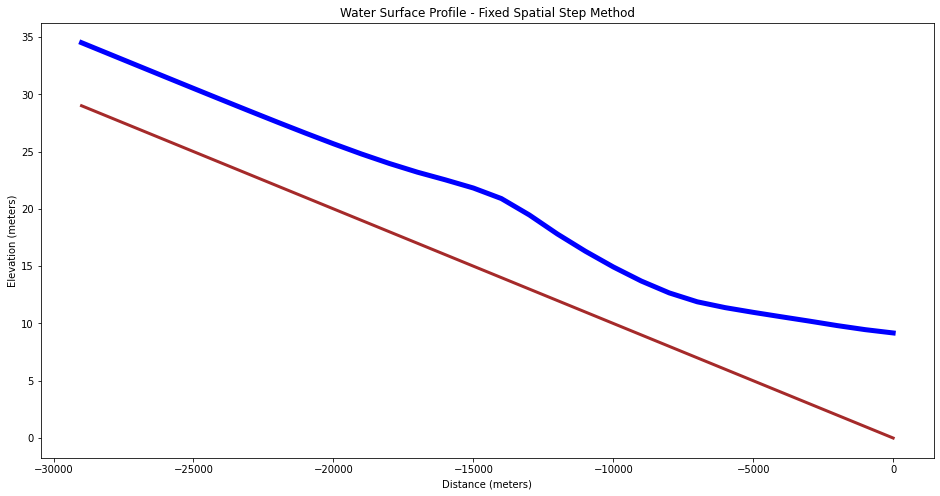

In [40]:
# Now plot the water surface profile
import matplotlib.pyplot
myfigure = matplotlib.pyplot.figure(figsize = (16,8)) # generate a object from the figure class, set aspect ratio
# Built the plot
matplotlib.pyplot.plot(distance, bottom,  color ='brown', linewidth=3)
matplotlib.pyplot.plot(distance, watersurface,  color ='blue', linewidth=5)
matplotlib.pyplot.ylabel("Elevation (meters)")
matplotlib.pyplot.xlabel("Distance (meters)")
mytitle = "Water Surface Profile - Fixed Spatial Step Method"
matplotlib.pyplot.title(mytitle)
matplotlib.pyplot.show()

## References
Koutitas, C. G. 1983. Elements of Computational Hydraulics. ISBN 0-412-00361-9. Pentech Press Ltd. London. (Chapter 4) [http://54.243.252.9/ce-5362-psuedo-course/3-Readings/PracticalComputationalHydraulics-Kousitas/ElementsOfComputationalHydraulics.pdf](http://54.243.252.9/ce-5362-psuedo-course/3-Readings/PracticalComputationalHydraulics-Kousitas/ElementsOfComputationalHydraulics.pdf)

Roberson, J. A., Cassidy, J.J., and Chaudry, M. H., (1988) Hydraulic Engineering, Houghton Mifflin Co (Chapter 10) [http://54.243.252.9/ce-5362-psuedo-course/3-Readings/HydraulicEngineering/](http://54.243.252.9/ce-5362-psuedo-course/3-Readings/HydraulicEngineering/)

Sturm T.W (2001) Open Channel Hydraulics, 1ed., McGraw-Hill, New York. Note: This PDF is from an international edition published in Singapore. [http://54.243.252.9/ce-5362-psuedo-course/3-Readings/OpenChannelHYdraulics/](http://54.243.252.9/ce-5362-psuedo-course/3-Readings/OpenChannelHYdraulics/)

Cunge, J.A., Holly, F.M., Verwey, A. (1980). Practical Aspects of Computational
River Hydraulics. Pittman Publishing Inc. , Boston, MA. pp. 7-50